<h1>Movie Trends Over Time. A Short History</h>

by: <i>James Trauger, Pushkar Bhargiri, Sid Su</i>

Movies have existed for well over a century. But in that time they have evolved and changed greatly. In this project, we are looking through various movie trends and what has changed over the years. We use various python tools and libraries to give us more information about our data. 

In [277]:
import requests
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 9)
from bs4 import BeautifulSoup
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8');

## Step 1: Data Collection

We start by collecting some data from IMDB. We have two data sets that we want to use, the basics and ratings one. The basics will give general information about our movies such as runtime, year, genre etc. The ratings will provide us with the average movie rating on a scale of 10 and number of votes per rating. We request and download this data and then write it to our directories. 

In [278]:
# downloading the data. These are datasets provided for non-commercial use
url= 'https://datasets.imdbws.com/title.basics.tsv.gz';
url2= 'https://datasets.imdbws.com/title.ratings.tsv.gz';

titledata= requests.get(url);
ratingdata= requests.get(url2);

title_filename= 'title_data.tsv.gz';
ratings_filename= 'ratings.tsv.gz';

# write the files to our directory
open(title_filename, 'wb').write(titledata.content);
open(ratings_filename, 'wb').write(ratingdata.content);

In [279]:
# reading the data into panda dataframes
title_df= pd.read_csv(title_filename, sep="\t", compression="gzip", dtype={'isAdult': str});
ratings_df= pd.read_csv(ratings_filename, sep="\t", compression="gzip");
print(title_df.head(5), ratings_df.head(5))

      tconst titleType            primaryTitle           originalTitle  \
0  tt0000001     short              Carmencita              Carmencita   
1  tt0000002     short  Le clown et ses chiens  Le clown et ses chiens   
2  tt0000003     short          Pauvre Pierrot          Pauvre Pierrot   
3  tt0000004     short             Un bon bock             Un bon bock   
4  tt0000005     short        Blacksmith Scene        Blacksmith Scene   

  isAdult startYear endYear runtimeMinutes                    genres  
0       0      1894      \N              1         Documentary,Short  
1       0      1892      \N              5           Animation,Short  
2       0      1892      \N              4  Animation,Comedy,Romance  
3       0      1892      \N             12           Animation,Short  
4       0      1893      \N              1              Comedy,Short         tconst  averageRating  numVotes
0  tt0000001            5.7      1971
1  tt0000002            5.8       263
2  tt0000003   

Now we collect some more data. We import box office data as well to get a better idea of how factors affect the box office success of movies. We employ a similar process to our data collection above except we have to iterate through 200 ranks at a time to scrape the data. 

In [280]:
# Collect box office data
box_office_url = 'https://www.boxofficemojo.com/chart/ww_top_lifetime_gross/?offset='
box_office_df = pd.DataFrame()
# iterate over each webpage 200 ranks at a time
for i in range(0,1000,200):
    # append the offset to the url
    box_req = requests.get(box_office_url + str(i))
    soup = BeautifulSoup(box_req.content, 'html.parser')
    # add the next 200 ranks to the current 
    box_office_df = pd.concat([box_office_df, pd.read_html(io=str(soup.find('table')))[0]])
box_office_df.head(10)

,Rank,Title,Worldwide Lifetime Gross,Domestic Lifetime Gross,Domestic %,Foreign Lifetime Gross,Foreign %,Year
0,1,Avatar,"$2,923,706,026","$785,221,649",26.9%,"$2,138,484,377",73.1%,2009
1,2,Avengers: Endgame,"$2,799,439,100","$858,373,000",30.7%,"$1,941,066,100",69.3%,2019
2,3,Avatar: The Way of Water,"$2,319,770,231","$684,020,678",29.5%,"$1,635,749,553",70.5%,2022
3,4,Titanic,"$2,264,743,257","$674,292,608",29.8%,"$1,590,450,649",70.2%,1997
4,5,Star Wars: Episode VII - The Force Awakens,"$2,071,310,218","$936,662,225",45.2%,"$1,134,647,993",54.8%,2015
5,6,Avengers: Infinity War,"$2,052,415,039","$678,815,482",33.1%,"$1,373,599,557",66.9%,2018
6,7,Spider-Man: No Way Home,"$1,921,847,111","$814,115,070",42.4%,"$1,107,732,041",57.6%,2021
7,8,Jurassic World,"$1,671,537,444","$653,406,625",39.1%,"$1,018,130,819",60.9%,2015
8,9,The Lion King,"$1,663,075,401","$543,638,043",32.7%,"$1,119,437,358",67.3%,2019
9,10,The Avengers,"$1,520,538,536","$623,357,910",41%,"$897,180,626",59%,2012


In [281]:
# Rename the 'Title' column to 'primaryTitle' to merge with the original dataframe
box_office_df.rename(columns={'Title': 'primaryTitle'},inplace=True)

Now we take our data and put it into a dataframe. We use the pandas library to read it in. Pandas is an extremely powerful library. We use it above to read in a csv file, but it can be used for many more sitautions. Refer to the API Reference page (https://pandas.pydata.org/docs/reference/) for full details.

## Step 2: Data Processing

Now we join our data into one dataframe. This allows us to easily compare the data across both files. We are able to use inner join and use 'tconst'. 'tconst' is a unique identifier for each piece of media making it very easy for us to join the two tables. To learn more about joins visit https://pandas.pydata.org/docs/user_guide/merging.html.

In [282]:
# Merge title and rating data, and remove unnecessary columns
df = pd.merge(left=title_df, right=ratings_df, on='tconst', how='inner');
df.drop(labels=['endYear'],axis=1, inplace=True); # used in shows, not relevant in this analysis
df.head(5);

We need to parse certain columns to integers

In [283]:
df.dtypes

tconst             object
titleType          object
primaryTitle       object
originalTitle      object
isAdult            object
startYear          object
runtimeMinutes     object
genres             object
averageRating     float64
numVotes            int64
dtype: object

In our dataset, there were all sorts of forms of media. Here we are only looking at movies so we can drop all other forms of media (short films, shows, ...). We are analyzing these movies over time thus, so we can also drop any movies without a release date ('startYear'). Then, we need to convert the release dates from strings to integers in order to plot them later on.

In [284]:
# keep only movies
df = df[df['titleType'] == 'movie']
# drop movies without a release date
df = df[df['startYear'] != '\\N']
# convert release date from strings to integers
df['startYear'] = df['startYear'].apply(int)

In [285]:
# convert to float type
to_number = lambda x: float(x) if x.isdigit() else np.nan
df['runtimeMinutes'] = df['runtimeMinutes'].apply(to_number)

In [286]:
# 1 if isAdult else, if it's any other value (0 or invalid)
function = lambda x: True if x == '1' else False
df['isAdult'] = df['isAdult'].apply(function)

In [287]:
df.head(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
8,tt0000009,movie,Miss Jerry,Miss Jerry,False,1894,45.0,Romance,5.3,204
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,False,1897,100.0,"Documentary,News,Sport",5.3,469
326,tt0000502,movie,Bohemios,Bohemios,False,1905,100.0,\N,4.1,15
358,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,False,1906,70.0,"Action,Adventure,Biography",6.0,826
366,tt0000591,movie,The Prodigal Son,L'enfant prodigue,False,1907,90.0,Drama,4.4,20


## Step 3: Exploratory Analysis and Data Vizualization

### Amount of movies

Let's look at how many movies were produced every year. Then we can plot it as a histogram with each bin counting 5 years worth of data.

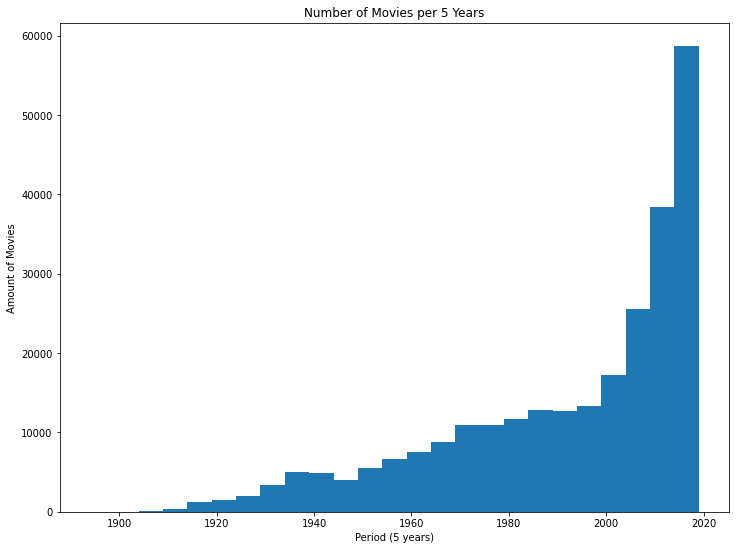

In [288]:
# count of movies for each year
years = df['startYear'];
# create bins of size 5 starting 
bins = np.arange(start=df['startYear'].min(),stop=df['startYear'].max(),step=5);
plt.xlabel('Period (5 years)');
plt.ylabel('Amount of Movies');
plt.title(label='Number of Movies per 5 Years');
plt.hist(x= years, bins=bins);

Observe as time progressed more and more movies were created. From the late 1800s to the late 1910s the camera and filming technology was limited and expensive, making it difficult to produce movies. As film and storage technology progressed, the demand to watch those movies also grew causing more to be produced.

This graph also tells a sad story about film storage. Nitrate film, which was used in the Silent, Talkie and Golden era of film is highly flamable due to chemical reactions that release oxygen as it burns. Over 90% of all silent films have been lost, and 70% of early talkies.

### Runtime

Next, let's look at the runtimes of movies over the years.

In [289]:
# Drop null values and store runtime by year
by_year= df[df['runtimeMinutes'] != '\\N']
by_year = by_year.dropna(axis=0, subset='runtimeMinutes').groupby(by='startYear')

In [290]:
by_year['runtimeMinutes'].head(10)

8          45.0
144       100.0
326       100.0
358        70.0
366        90.0
          ...  
619272     90.0
649109     52.0
734933    120.0
780545     45.0
867340     61.0
Name: runtimeMinutes, Length: 1159, dtype: float64

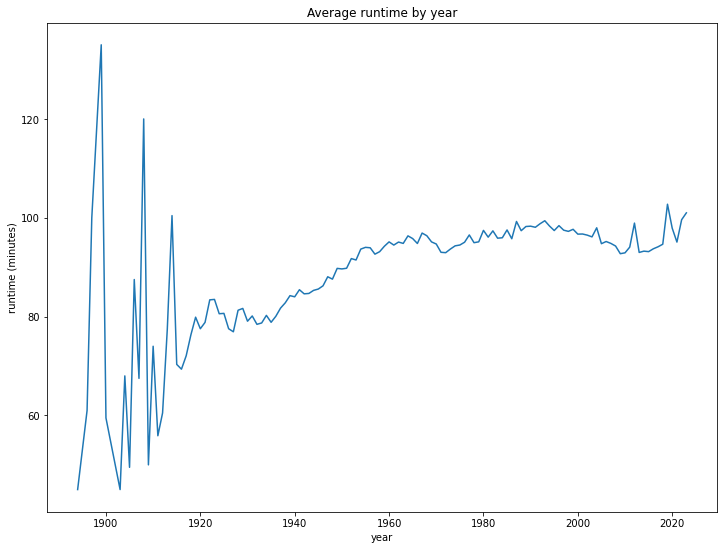

In [291]:
#Find average runtime of each year and plot it

avgs = by_year['runtimeMinutes'].mean()
plt.xlabel('year')
plt.ylabel('runtime (minutes)')
plt.title('Average runtime by year')
plt.plot(avgs)

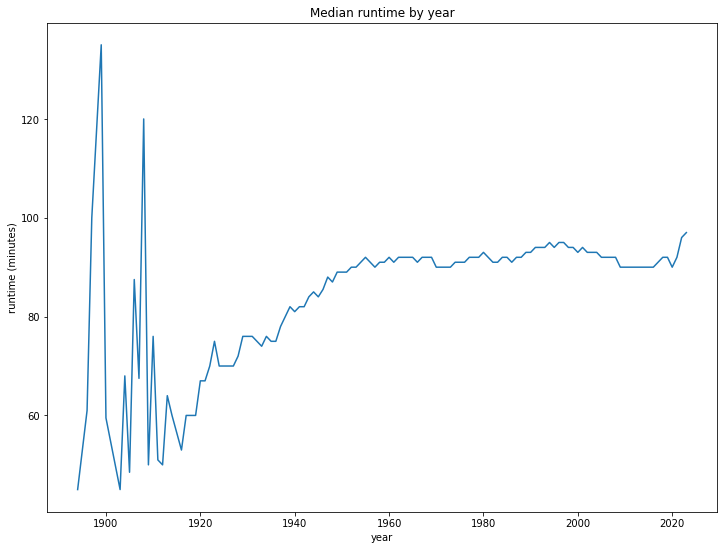

In [292]:
plt.xlabel('year')
plt.ylabel('runtime (minutes)')
plt.title('Median runtime by year')
plt.plot(by_year['runtimeMinutes'].median())

The average and median runtimes of movies has a clear positive trend initially and then, flattened out to about 90 minutes. In the early 20th century, there were barely any movies thus, it was much more sensitive to outliers. Then, as more movies were produced, the runtime stabilized and followed a trend over the years. Similar to the quantity of movies, it could be that movies grew in length partially due to better techonolgy until moviemakers decided 90 minutes is a good balance of time to both tell a complete story and keep the audience's attention. 

### Genres

Now let us take a look at the various genres of movies made over time. 

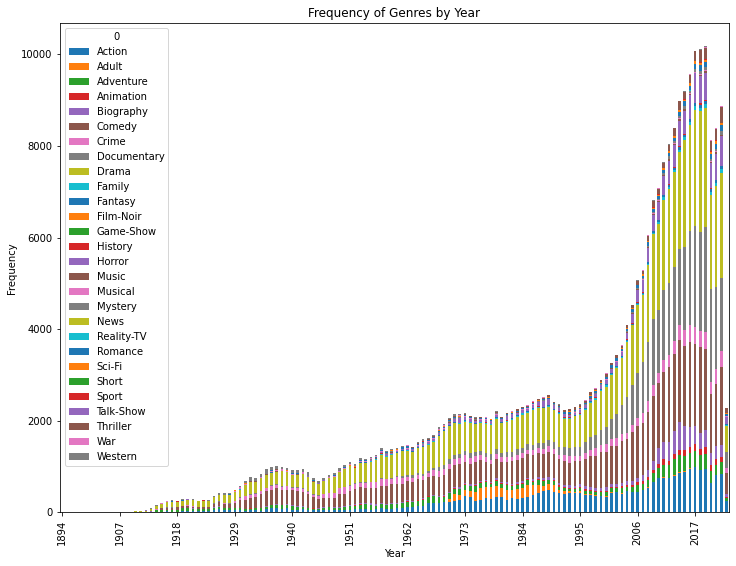

In [293]:
#This block is looking at the frequency of genre over time
#The first step is to split a data cell of a movie with multiple genres into separate cells
genre = df['genres'].str.split(",", n=2, expand = True)
#Then we add in year into our new dataframe
genre.insert(3, "year", df['startYear'], True)
#We delete NaN and Null values
genre = genre[genre[0] != '\\N']
#We drop the secondary and tertiary genres as we are only looking at the primary genre
genre.drop([1, 2], axis=1)
#We then group the genre by year and put it in a data frame
genre_tot = genre[[0, 'year']].groupby('year')[0].value_counts().reset_index(name='count')
#Now we plot our data in a stacked bar graph
genre.groupby(['year', 0]).size().unstack().plot.bar(stacked=True, figsize=(12, 9));
#We set 12 x ticks
plt.locator_params(axis='x', nbins=12);
#We label our graph
plt.xlabel("Year");
plt.ylabel("Frequency");
plt.title("Frequency of Genres by Year");

In this block, we separated the genres and found a count of them for each year. We then used that data to plot a stacked bar chart. The bar chart function allows a number of arguments allowing advanced pandas users to have great customizability. For more details specifically about stacked bar charts visit https://www.statology.org/pandas-stacked-bar-chart/.

Here we had to first clean up the genre cells. These cells oftentimes had multiple genres listed with a comma separating each genre. We separated the genres and looked at primary genres to keep all movies on an even playing field. The graph shows how the sheer quantity of movies have grown. One genre that peaked in the 21st century is comedies. Action movies also grew from the mid 20th century onwards. Dramas and documentaries followed a similar path growing over time as well. Musicals have stayed relatively stagnant as other genres have grown. This may be because of the difficult nature to making a good musical. It requires good storytelling along with music composition. As it has become a lot easier to write and produce small budget movies of other genres with new and better technology, writing a musical remains a tough task.

In [294]:
df.sort_values(by=['numVotes'], ascending=False).head(10)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes
82557,tt0111161,movie,The Shawshank Redemption,The Shawshank Redemption,False,1994,142.0,Drama,9.3,2737560
250364,tt0468569,movie,The Dark Knight,The Dark Knight,False,2008,152.0,"Action,Crime,Drama",9.0,2710629
637745,tt1375666,movie,Inception,Inception,False,2010,148.0,"Action,Adventure,Sci-Fi",8.8,2406192
99043,tt0137523,movie,Fight Club,Fight Club,False,1999,139.0,Drama,8.8,2179773
81462,tt0109830,movie,Forrest Gump,Forrest Gump,False,1994,142.0,"Drama,Romance",8.8,2130268
82340,tt0110912,movie,Pulp Fiction,Pulp Fiction,False,1994,154.0,"Crime,Drama",8.9,2103714
96895,tt0133093,movie,The Matrix,The Matrix,False,1999,136.0,"Action,Sci-Fi",8.7,1952760
90341,tt0120737,movie,The Lord of the Rings: The Fellowship of the Ring,The Lord of the Rings: The Fellowship of the Ring,False,2001,178.0,"Action,Adventure,Drama",8.8,1911387
46210,tt0068646,movie,The Godfather,The Godfather,False,1972,175.0,"Crime,Drama",9.2,1903690
395446,tt0816692,movie,Interstellar,Interstellar,False,2014,169.0,"Adventure,Drama,Sci-Fi",8.6,1901627


<b>Are films getting better or worse as time goes by?</b>

Average each year's rating, and graph

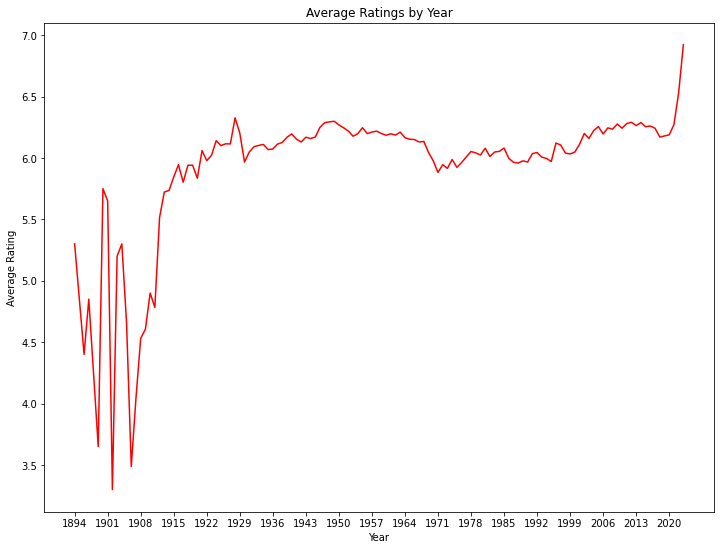

In [295]:
# convert the ratings to floats to make analysis easier
df_avg_rating= df.groupby(by= 'startYear')['averageRating'].mean();
df_avg_rating.plot.line(x= 'startingYear', y= 'averageRating', figsize= (12, 9), xlabel= 'Year', ylabel= 'Average Rating', \
                        color= 'red', title= 'Average Ratings by Year', xticks= range(1894, 2023, 7));

We can see a trend that after the early years with very few films, the average rating stabilizes. Interestingly, between the mid-60s and early 2000s, there is a dip in the average rating of films. What is odd is the sudden spike in recent years. This could be explained by <a href="https://deadline.com/2020/03/vin-diesel-bloodshot-i-still-believe-the-hunt-weekend-box-office-coronavirus-1202882333">how few films came out during the pandemic</a>, so critics were happy to have anything. It will be interesting to see where this trend goes over time now that the pandemic is mostly over.

However, this is a bit muddied, since many movies have few ratings. If we only take movies with >50 ratings (the Rotten Tomatoes criteria for rating listing and ranking), then we get different results.

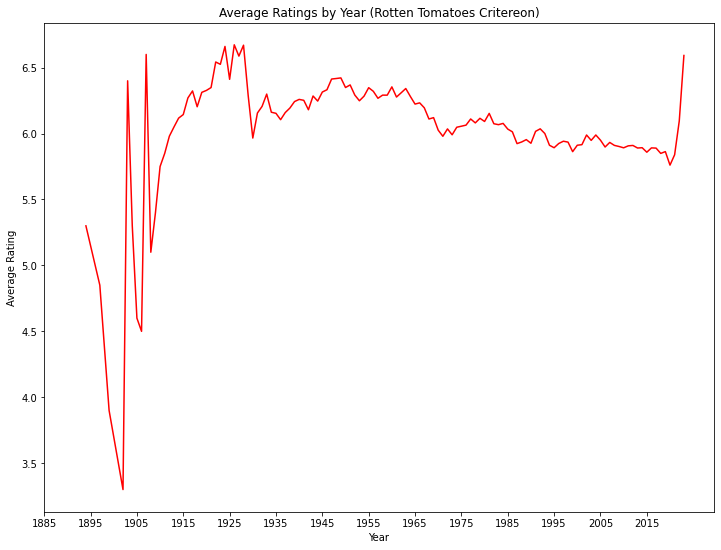

In [296]:
# convert the ratings to floats to make analysis easier
df_avg_rating2= df[df['numVotes'] >= 50]
df_avg_rating2= df_avg_rating2.groupby(by= 'startYear')['averageRating'].mean();

df_avg_rating2.plot.line(x= 'startingYear', y= 'averageRating', figsize= (12, 9), xlabel= 'Year', ylabel= 'Average Rating', \
                        color= 'red', title= 'Average Ratings by Year (Rotten Tomatoes Critereon)', xticks= range(1885, 2023, 10));

By cutting films with fewer than 50 ratings, we can see that ratings after roughly 1929 appear to go down in quality. As some inital hypotheses, the Great Depression could have led to more, but lower quality films being produced, lowering the average. We cannot yet extrapolate that films are getting worse, because it could be that simply more films are being made. In this way the trend towards lower ratings could represent a democratization of filmmaking, at the cost of some SharkNados getting through.

<b>Do critics have an appetite for mature themes?</b>

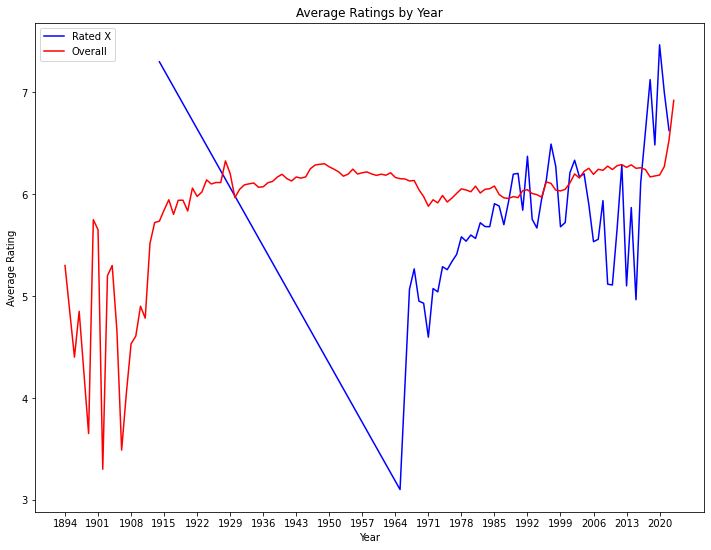

In [297]:
df_avg_rating= df.groupby(by= 'startYear')['averageRating'].mean();
df_rated_x= df[df['isAdult'] == True].groupby(by= 'startYear')['averageRating'].mean();
df_rated_x.plot.line(x= 'startingYear', y= 'averageRating', figsize= (12, 9), xlabel= 'Year', ylabel= 'Average Rating', \
                        color= 'blue', label= 'Rated X', title= 'Average Ratings by Year', xticks= range(1894, 2023, 7));
df_avg_rating.plot.line(x= 'startingYear', y= 'averageRating', figsize= (12, 9), xlabel= 'Year', ylabel= 'Average Rating', \
                        color= 'red', label= 'Overall', title= 'Average Ratings by Year', xticks= range(1894, 2023, 7));
plt.legend();

This plot tells a story about censorship in the US. The gap between 1914 and 1964 represents the years where Hays Code were active, and thus Rated X movies and their themes were not allowed. Interestingly, Hays code came into effect 1934, so it may also be in part due to incomplete iMDB data. Incomplete data also tells a story about how over 90% of silent films and over 70% of films from both the silent to early talkie era have been lost.

As the 60s and 70s went on, X rated films reviewed better coinciding with the sexual liberation movement or sexual revolution. Additionally, crime movies with extreme violence gained prominence, spurred on by the commercially successful and critically acclaimed film, The Godfather (1972).

### Amount of movies

Let's look at how many movies were produced every year. Then we can plot it as a histogram with each bin counting 5 years worth of data.

(array([4.0000e+00, 9.0000e+00, 4.5000e+01, 2.9500e+02, 1.2290e+03,
        1.4880e+03, 2.0050e+03, 3.3950e+03, 4.9950e+03, 4.9030e+03,
        4.0460e+03, 5.5450e+03, 6.6400e+03, 7.4880e+03, 8.7680e+03,
        1.0979e+04, 1.0963e+04, 1.1721e+04, 1.2835e+04, 1.2713e+04,
        1.3397e+04, 1.7296e+04, 2.5548e+04, 3.8394e+04, 5.8730e+04]),
 array([1894., 1899., 1904., 1909., 1914., 1919., 1924., 1929., 1934.,
        1939., 1944., 1949., 1954., 1959., 1964., 1969., 1974., 1979.,
        1984., 1989., 1994., 1999., 2004., 2009., 2014., 2019.]),
 <BarContainer object of 25 artists>)

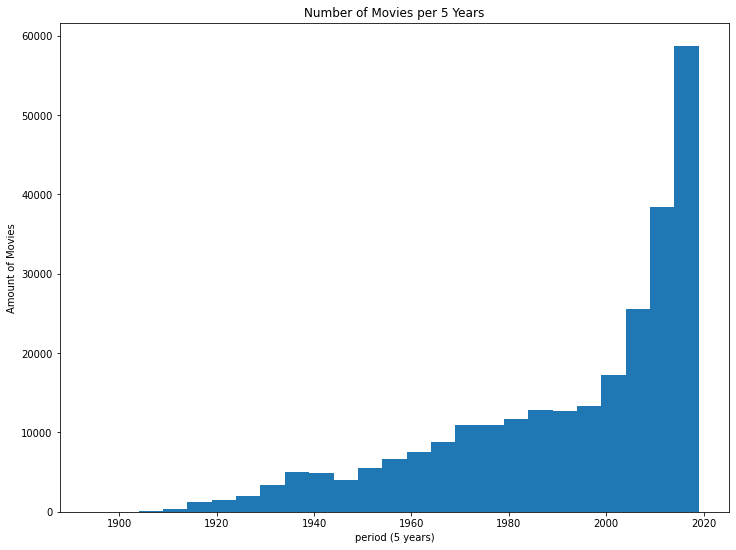

In [298]:
# count of movies for each year
years = df['startYear']
# create bins of size 5 starting 
bins = np.arange(start=df['startYear'].min(),stop=df['startYear'].max(),step=5)
plt.xlabel('period (5 years)')
plt.ylabel('Amount of Movies')
plt.title(label='Number of Movies per 5 Years')
plt.hist(x=years,bins=bins)

Observe as time progressed more and more movies were created. From the late 1800s to the late 1910s the camera and filming technology was very limited making it difficult to produce movies. Then, as the technology to film and store movies became more advance the demand to watch those movies also grew causing more to be produced. 

### Runtime

Next, let's look at the runtimes of movies over the years.

In [299]:
by_year = df.dropna(axis=0,subset='runtimeMinutes').groupby(by='startYear')

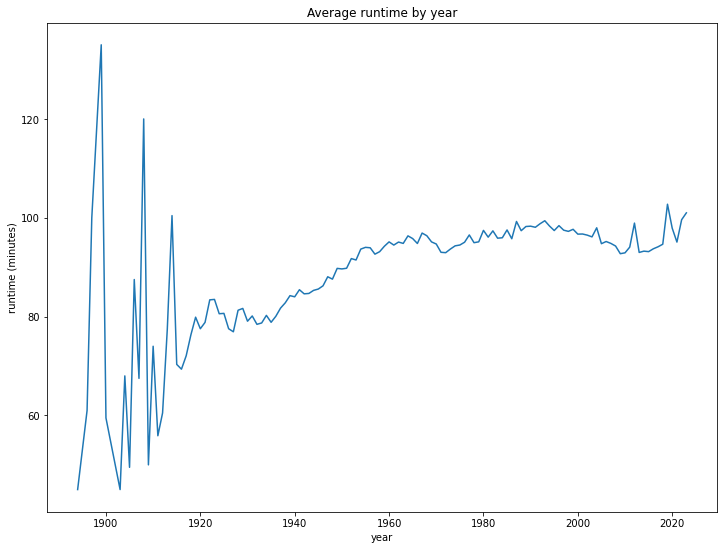

In [300]:
avgs = by_year['runtimeMinutes'].mean()
plt.xlabel('year')
plt.ylabel('runtime (minutes)')
plt.title('Average runtime by year')
plt.plot(avgs)

How will the median runtime fair?

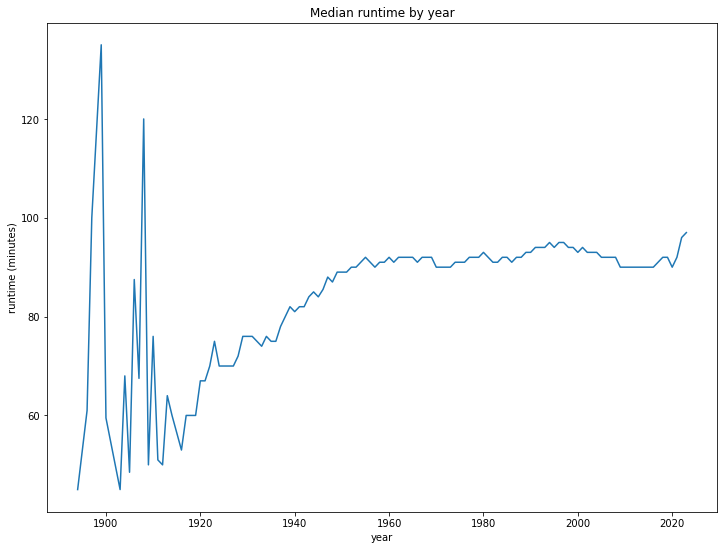

In [301]:
plt.xlabel('year')
plt.ylabel('runtime (minutes)')
plt.title('Median runtime by year')
plt.plot(by_year['runtimeMinutes'].median())

The average and median runtimes of movies has almost an upwards trend then, flattened out to about 90 minutes. In the early 20th century, there were barely any movies thus, it was much more sensitive to outliers. Then, as more movies were produced, the runtime stabilized and followed a trend over the years.

### Box office

To see the ratings and genres of the top 1000 box office movies, we need to merge it with our original dataframe. By performing a 'right' merge we move all the rating, votes, and genres columns to the box office dataframe. Both dataframes share a title column that we can use to merge on.

In [ ]:
# TODO move to step 2 

# add the averageRatings numVotes, and genres to the box office dataframe
# df would be the 'left' set and box_office_df would be the 'right' set
boxdf = df[['primaryTitle', 'genres', 'averageRating', 'numVotes', 'runtimeMinutes']].merge(box_office_df, how='right', on='primaryTitle')
# remove the duplicates of movies with the highest number of votes
boxdf = boxdf.sort_values('numVotes', ascending=False).drop_duplicates('primaryTitle').sort_values(by='Rank')
boxdf.head(5)

We need to convert all the currencies to actual numbers for Python to process

In [ ]:
# given a dollar amount ($123,456,789), this function removes the currecny symbol 
# then, it parses the comma delimited number.
convert = lambda x: locale.atof(x.strip('$')) if x != '-' else np.nan
# apply this function to each of the revenue columns to convert them to floats
boxdf['Worldwide Lifetime Gross'] = boxdf['Worldwide Lifetime Gross'].apply(convert)
boxdf['Domestic Lifetime Gross'] = boxdf['Domestic Lifetime Gross'].apply(convert)
boxdf['Foreign Lifetime Gross'] = boxdf['Foreign Lifetime Gross'].apply(convert)
boxdf.head(5)

Now let's plot it. We can see the highest grossing movies (> 1.5 billion dollars) have pretty high ratings. However, there are still many movies with average or poor ratings that make lots of money. Just because a movie does well in the box office does not mean it will rate highly.

In [ ]:
figure, (axis1, axis2) = plt.subplots(1,2)

# plot the top 1000 box office movies
axis1.set_xlabel('average rating')
axis1.set_ylabel('Worldwide Lifetime Gross')
axis1.set_title('Top 1000 Box Office Movies')
axis1.scatter(x=boxdf['averageRating'], y=boxdf['Worldwide Lifetime Gross'])

# plot all movies
axis2.set_xlabel('number of votes')
axis2.set_ylabel('average rating (out of 10)')
axis2.set_title('Top 1000 Box Office Movies')
axis2.scatter(x=boxdf['numVotes'], y=boxdf['Worldwide Lifetime Gross'])

figure.set_size_inches(12,6)
plt.show()

How about runtime? Most of the high grossing movies are between 90 and 150 minutes. 

In [ ]:

figure, (axis1, axis2) = plt.subplots(1,2)
x = 'runtime (minutes)'

# plot the top 1000 box office movies
axis1.set_xlabel(x)
axis1.set_ylabel('Worldwide Lifetime Gross')
axis1.set_title('Top 1000 Box Office Movies')
axis1.scatter(boxdf['runtimeMinutes'], boxdf['Worldwide Lifetime Gross'])

# plot all movies
axis2.set_xlabel(x)
axis2.set_ylabel('amount of movies')
axis2.set_title('Runtime Distribution')
axis2.hist(boxdf['runtimeMinutes'], bins=15)

figure.set_size_inches(12,6)
plt.show()

## Analysis, Hypothesis Testing, and Machine Learning

Let's first analyze the highest grossing movies that have at least one rating for the viewers

In [313]:
boxdf = boxdf.dropna(how='all',subset='numVotes')
# rename to remove spaces
boxdf = boxdf.rename(columns={'Worldwide Lifetime Gross': 'boxOffice'})
# take a subset of the movies with at least 15,0000 votes
thousand = df[df['numVotes'] > 15000].copy()

There appears to be a logarithmic relationship between the number of votes and average rating. Both the 1000 highest grossing movies and the entire dataset show this relationship.

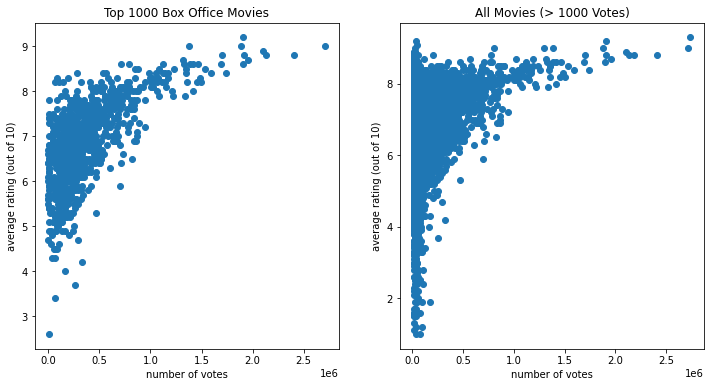

In [314]:
figure, (axis1, axis2) = plt.subplots(1,2)

# plot the top 1000 box office movies
axis1.set_xlabel('number of votes')
axis1.set_ylabel('average rating (out of 10)')
axis1.set_title('Top 1000 Box Office Movies')
axis1.scatter(boxdf['numVotes'], boxdf['averageRating'])

# plot all movies
axis2.set_xlabel('number of votes')
axis2.set_ylabel('average rating (out of 10)')
axis2.set_title('All Movies (> 1000 Votes)')
axis2.scatter(thousand['numVotes'], thousand['averageRating'])

figure.set_size_inches(12,6)
plt.show()

Let's test how a linear regression model will perform. We want to predict the average rating based on the number of votes. The LinearRegression and statsmodels libraries have many helpful and easy to use machine learning models for us to use.

In [ ]:
from sklearn.linear_model import LinearRegression
from statsmodels.formula import api as stats

We will be using ordinary least squares regression to fit the number of votes to the average rating.

In [315]:

lin_model = stats.ols(formula='averageRating ~ numVotes', data=thousand).fit()

We can now plot the results. It seems this model is inaccurate as the residuals are not normally distributed. If there was a true linear relationship between the number of votes and rating then the errors in our predictions (residuals) should be normally distributed.

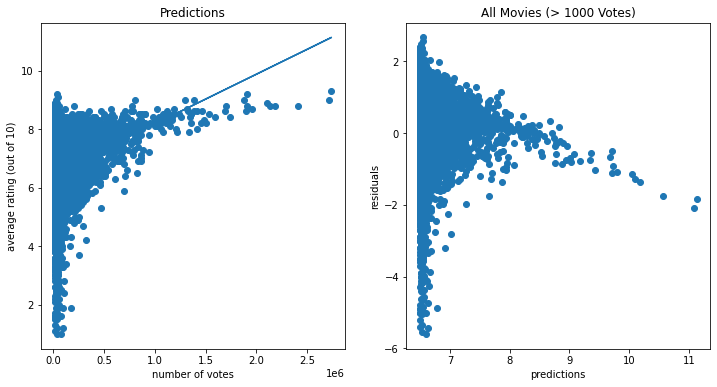

In [316]:
votes = thousand['numVotes']
preds = lin_model.predict(votes)

figure, (axis1, axis2) = plt.subplots(1,2)

# plot the number of votes vs rating with the linear regression model
axis1.set_xlabel('number of votes')
axis1.set_ylabel('average rating (out of 10)')
axis1.set_title('Predictions')
axis1.scatter(x=votes, y=thousand['averageRating'])
axis1.plot(votes, lin_model.predict(votes))

# plot all movies
axis2.set_xlabel('predictions')
axis2.set_ylabel('residuals')
axis2.set_title('All Movies (> 1000 Votes)')
axis2.scatter(x=preds, y=lin_model.resid)

figure.set_size_inches(12,6)
plt.show()

Let's take am exponential transform of the average rating. As more movies are rated, it has a lesser impact on the average rating. We start to see diminshing return for the average rating as the number of votes increases.

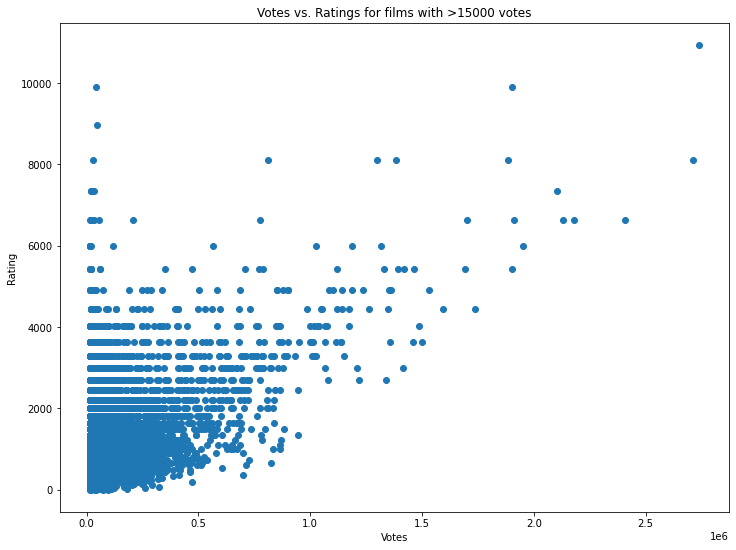

In [319]:
thousand['logRating'] = thousand['averageRating'].apply(np.exp);
exp_model = stats.ols(formula='logRating ~ numVotes',data=thousand).fit();
plt.scatter(votes,thousand['logRating']);
plt.xlabel('Votes');
plt.ylabel('Rating');
plt.title('Votes vs. Ratings for films with >15000 votes');

Although we cannot conclude much if we take votes vs ratings directly, if we limit ourselves to "popular" movies that have >15000 ratings, we see that popularity and critical acclaim do appear to be correlated. However, we cannot conclude any causation still, because in the real world votes and rating are not at all independent. If the highest rated movie tends to win awards, then this popularity will generate a boost in ticket sales and the amount of people who could write a rating.

Additionally, a lot of data is removed. We went from millions of data points to 91564, because there are only so many popular films.

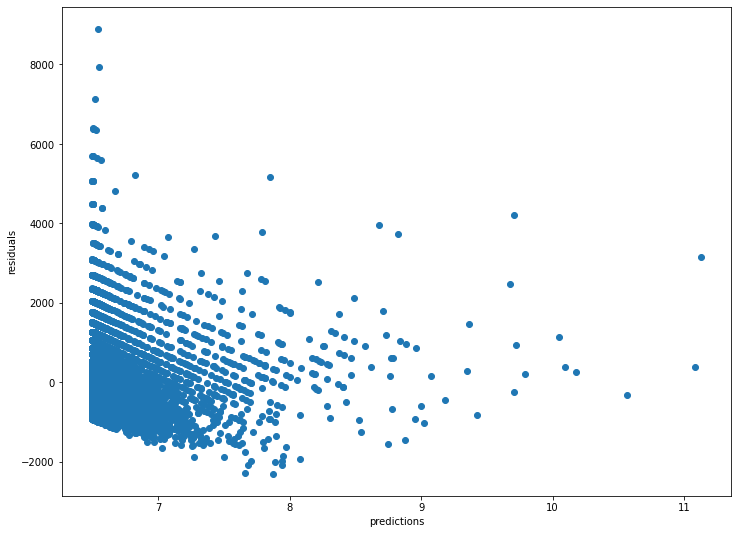

In [321]:
log_preds = exp_model.predict(votes);
plt.xlabel('predictions');
plt.ylabel('residuals');
plt.scatter(preds, exp_model.resid);

Looking at the residual graph for the previous scatter plot, we still see a high variation among movies with fewer votes. This is could be solved by taking even rating count threshholds, but doing so would be less an analysis of popular films, but rather of the best films of all time.

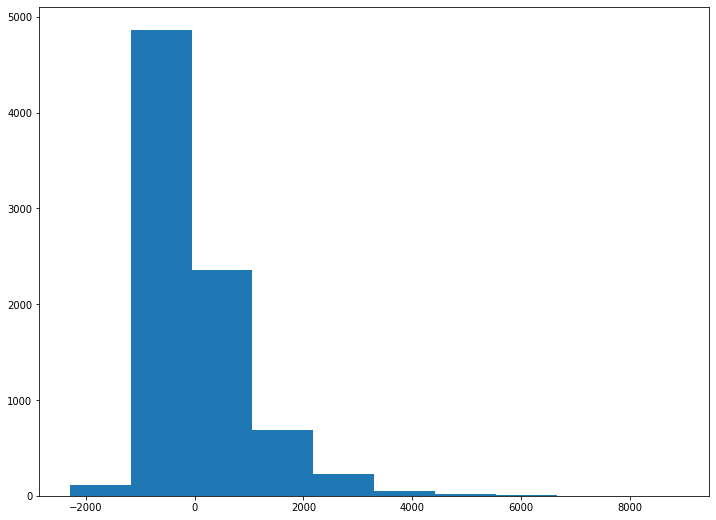

In [322]:
plt.hist(exp_model.resid);

The histogram is right-skewed, which means that many films tend to overperform better than the number of reviews would suggest.

## Insight and Policy Decision

## Conclusion